In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [6]:

# Here we load the images and do some preprocessing for them. We do the following preprocessing steps:
# - transform the into arrays
# - resize them to a smaller resolution
# - convert the image to B&W
# - Normalize the arrays

def transform_image(kuva):

    kuva = Image.open(kuva)
    new_size = (256, 256)

    resized_image = kuva.resize(new_size, Image.BILINEAR)

    kuva_array = tf.keras.preprocessing.image.img_to_array(resized_image)
    normalized_array = (kuva_array - kuva_array.min()) / (kuva_array.max() - kuva_array.min())
    type(normalized_array)
    return normalized_array


# Iterating through the folders to apply preprocessing for all images in the dataset 

def go_through_folder(folder):
    array_list =[]
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        array = transform_image(file_path)
        array_list.append(array)
        
    return array_list
        
#test_image = transform_image("output/train/benign/SOB_B_A-14-22549AB-400-001.png")   
benign_train = np.array(go_through_folder("output/train/benign"))
malignant_train = np.array(go_through_folder("output/train/malignant"))
benign_test = np.array(go_through_folder("output/test/benign"))
malignant_test = np.array(go_through_folder("output/test/malignant"))
benign_val = np.array(go_through_folder("output/val/benign"))
malignant_val = np.array(go_through_folder("output/val/malignant"))


/tmp/ipykernel_448/1857767185.py:12: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  resized_image = kuva.resize(new_size, Image.BILINEAR)


In [8]:
# Creating the Y labels for their respective images, 1 being a malignant tumor, 0 being a benign tumor
# Also preparing them to their respective train and test sets
benign_train_label = np.zeros(len(benign_train))
benign_test_label = np.zeros(len(benign_test))

malignant_train_label = np.ones(len(malignant_train))
malignant_test_label = np.ones(len(malignant_test))

malignant_val_label = np.ones(len(malignant_val))
benign_val_label = np.zeros(len(benign_val))

min_samples = min(len(benign_train), len(malignant_train))

if len(benign_train) > len(malignant_train):
    indices = np.random.choice(len(benign_train), min_samples, replace=False)  # Valitaan satunnaisesti indeksejä
    benign_train = benign_train[indices]
    benign_train_label = benign_train_label[indices]
else:
    indices = np.random.choice(len(malignant_train), min_samples, replace=False)  # Valitaan satunnaisesti indeksejä
    malignant_train = malignant_train[indices]
    malignant_train_label = malignant_train_label[indices]
    


    
print(len(benign_train), len(malignant_train))

X_train = np.concatenate((benign_train, malignant_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malignant_train_label), axis = 0)


X_test = np.concatenate((benign_test, malignant_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malignant_test_label), axis = 0)

X_val = np.concatenate((benign_val, malignant_val), axis = 0)
Y_val = np.concatenate((benign_val_label, malignant_val_label), axis = 0)


s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
Y_val = Y_val[s]



382 382


In [9]:
# Generating new data based on the original images (rotating, shifting, shearing, zooming images, etc) 


datagen = ImageDataGenerator(
    rotation_range=15,            
    width_shift_range=0.2,      
    height_shift_range=0.2,      
    shear_range=0.2,             
    zoom_range=0.2,             
    horizontal_flip=True,        
    vertical_flip=False,         
    fill_mode='nearest'         
)

datagen.fit(X_train)



In [10]:
# Creating the neural network

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

2023-09-22 17:56:13.494809: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(X_train.shape)
optimizer = Adam(learning_rate = 0.00001)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, Y_train), batch_size = 16, 
                    epochs=7,
                    validation_data=(X_val, Y_val))


(764, 256, 256, 3)
Epoch 1/7
 3/24 [==>...........................] - ETA: 3:08 - loss: 0.7005 - accuracy: 0.5417

In [ ]:
prediction = model.predict(X_test)

real_prediction = []
for i in prediction:
    if i >= 0.5:
        i = 1
    else:
        i = 0
        
    real_prediction.append(i)

accuracy = accuracy_score(Y_test, real_prediction)
accuracy

8/8 - 1s - loss: 0.4538 - accuracy: 0.8164 - 1s/epoch - 138ms/step


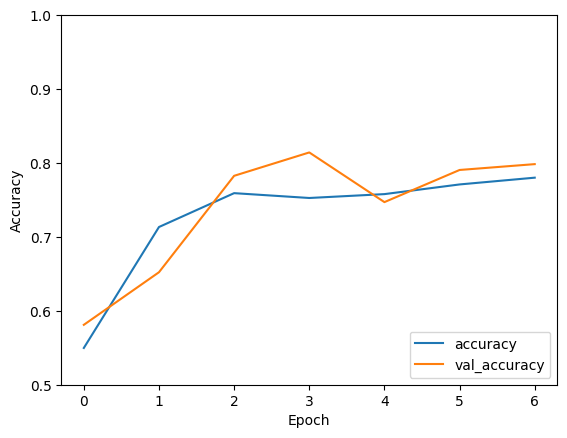

In [307]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  Y_test, verbose=2)

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.ylim([0, 0.8
         ])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='lower right')

